In [86]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [87]:
import matplotlib.pyplot as plt
from src.experiments.plot_utils import *
from collections import defaultdict

In [96]:
import scienceplots
plt.style.use([ 'science']) # 'notebook' 'science'
plt.rcParams.update({'font.size': 13})

In [97]:
PLOT_DIR = "../experiments/plots/4-modalities"

BASE_DIR = "/Users/yavuz/scalable-multimodal-similarity-search/experiments/"
CONSTRUCTION_DIR = BASE_DIR + "construction/"
SEARCH_DIR = BASE_DIR + "search/"
EXACT_RESULTS_FOLDER = BASE_DIR + "exact_results/"
SAVED_INDEX_DIR = BASE_DIR + "saved_index/"
STATS_BASE_FOLDER = BASE_DIR + "stats-experiments/"

STATS_SEARCH_WEIGHTS_DIR = STATS_BASE_FOLDER + "search_weights_exps/"

FIGURE_DPI = 200

In [369]:
def plot_4_modality_search_weights(params, construction_params, search_weights_data, ef=50, plots_dir=PLOT_DIR, num_recalls=100):
    weights = sorted(search_weights_data.keys())
    recalls = []
    for (w1, w2, w3, w4) in weights:
        weight_recalls = search_weights_data[(w1, w2, w3, w4)][ef]
        assert len(weight_recalls[0]) == num_recalls, f"Expected {num_recalls} recalls, but got {len(weight_recalls[0])} for weights {w1}, {w2}, {w3}, {w4} and ef {ef}"
        recalls.append(np.mean(weight_recalls))

    assert len(weights) == len(recalls), f"Expected {len(weights)} weights, but got {len(recalls)} recalls"
    print(f"Plotting {len(weights)} weight-recall points")

    w1, w2, w3, w4 = zip(*weights)
    recalls = np.array(recalls)

    fig = plt.figure(figsize=(10, 7))
    ax = fig.add_subplot(111, projection='3d')

    # scatter plot
    scatter = ax.scatter(w1, w2, w3, c=recalls, cmap='viridis', s=30)
    ax.set_xlabel('Text weight ($w_1$)')
    ax.set_ylabel('Image weight ($w_2$)')
    ax.set_zlabel('Audio weight ($w_3$)')

    # colorbar
    cbar = plt.colorbar(scatter)
    cbar.set_label('Average Recall')

    # plot index weights as a red circle
    ax.scatter(params.weights[0], params.weights[1], params.weights[2], c='red', linewidths=3, s=100, label=f'Index Weights={params.weights}')

    # plot plane
    w1_range = np.linspace(0, 1, 50)
    w2_range = np.linspace(0, 1, 50)
    W1, W2 = np.meshgrid(w1_range, w2_range)
    W3 = 1 - W1 - W2

    # only plot when W3 >= 0
    valid_mask = W3 >= 0
    W1_valid = np.where(valid_mask, W1, np.nan)
    W2_valid = np.where(valid_mask, W2, np.nan)
    W3_valid = np.where(valid_mask, W3, np.nan)
    plane = ax.plot_surface(
        W1_valid, W2_valid, W3_valid,
        color='blue', alpha=0.2, label='$w_1 + w_2 + w_3 = 1$'
    )

    # manually add the plane to the legend (since plot_surface doesn't support legend by default)
    plane._edgecolors2d = plane._edgecolor3d
    plane._facecolors2d = plane._facecolor3d
    ax.legend()

    info_text = (
        f"Dimensions: {params.dimensions}\n"
        f"Metrics: {metrics_to_str(params.metrics)}\n"
        f"Weights: {params.weights}\n"
        f"Target Degree: {construction_params.target_degree}\n"
        f"Max Degree: {construction_params.max_degree}\n"
        f"EfConstruction: {construction_params.ef_construction}\n"
        f"EfSearch: {ef}\n"
        f"Video Weight ($w_4$) = 1 - $w_1$ - $w_2$ - $w_3$"
    )

    plt.annotate(
        info_text,
        xy=(0.4, 0.55),
        xycoords='axes fraction',
        bbox=dict(
            boxstyle='round,pad=0.3',
            edgecolor='black',
            facecolor='lightgray'),
        fontsize=12,
        ha='left'
    )

    plt.title(f'Impact of Search Weights on Recall For Equally Weighted 4-Modality Index')
    plt.tight_layout()

    #ax.view_init(elev=10, azim=380)
    ax.view_init(elev=20, azim=-60)

    print(f"Elev: {ax.elev}, Azim: {ax.azim}")

    plt.savefig(f"{plots_dir}/search_weights/recall_3dheatmap_{params.index_size}_{params.metrics[0]}_{params.metrics[1]}_{params.metrics[2]}_{params.metrics[3]}_weights_{params.weights[0]}_{params.weights[1]}_{params.weights[2]}_{params.weights[3]}_deg_{construction_params.target_degree}_maxdeg_{construction_params.max_degree}_efConstruction_{construction_params.ef_construction}_seed_{construction_params.seed}_k{params.k}_ef_{ef}.pdf", dpi=FIGURE_DPI, bbox_inches='tight')

    plt.show()

In [213]:
params = Params(4, dimensions=[384, 768, 768, 512], metrics=["cosine"]*4, weights=[0.25, 0.25, 0.25, 0.25], index_size=9000)
construction_params = MultiVecHNSWConstructionParams(4, 8, 50, 400)
normalised = "normalised/"

In [190]:
search_weights_data, k = get_search_weights_data(params, construction_params, base_folder=STATS_SEARCH_WEIGHTS_DIR+normalised, modalities=4, prev_index_folder=1)
# search_weights_data: (w1, w2, w3, w4) -> ef -> recall

Loaded index-2025-04-29_20-40-30-191
Read values for k=10 for dataset size 9000 for 19 ef values


In [243]:
point_count = 500
keys = list(search_weights_data.keys())
# select a random subset of search_weights_data
selected = np.random.choice(len(keys), point_count, replace=False)
search_weight_data_to_plot = {}
for key in selected:
    search_weight_data_to_plot[keys[key]] = search_weights_data[keys[key]]
assert len(search_weight_data_to_plot) == point_count

Plotting 500 weight-recall points
Elev: 20, Azim: -60


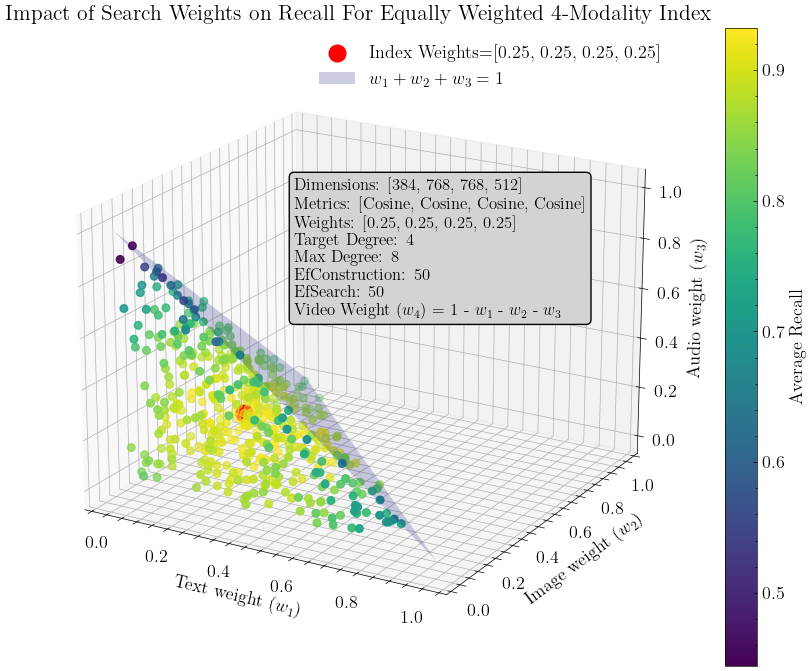

In [370]:
plot_4_modality_search_weights(params, construction_params, search_weight_data_to_plot)